In [50]:
import pandas as pd
from pathlib import Path

def load_and_process_admissions_csv(path: str | Path, year: str) -> pd.DataFrame:
    """Load admissions CSV with two header rows, flatten headers, and compute derived columns."""

    # --- Load and flatten headers ---
    header_df = pd.read_csv(path, nrows=2, header=None)
    combined_headers = [
        f"{r1.strip()}_{r2.strip()}" if pd.notna(r1) and pd.notna(r2)
        else r1.strip() if pd.notna(r1)
        else r2.strip()
        for r1, r2 in zip(header_df.iloc[0], header_df.iloc[1])
    ]

    # Deduplicate names safely without touching pandas internals
    seen = {}
    clean_headers = []
    for h in combined_headers:
        if h in seen:
            seen[h] += 1
            clean_headers.append(f"{h}_{seen[h]}")
        else:
            seen[h] = 0
            clean_headers.append(h)

    df = pd.read_csv(path, skiprows=2, names=clean_headers)
    df['year'] = year

    df = df[
        df["PARENT1_employment_status"].notna() &
        (df["PARENT1_employment_status"].astype(str).str.strip() != "")
    ].copy()

    # --- Normalize employment columns ---
    emp_cols = [f"PARENT{i}_employment_status" for i in range(1, 5)]
    for col in emp_cols:
        if col not in df.columns:
            df[col] = None

    def is_working(val):
        if isinstance(val, str):
            val = val.strip().lower()
            return val in ['employed', 'self-employed']
        return False

    for i in range(1, 5):
        df[f'Parent{i}_works'] = df[f'PARENT{i}_employment_status'].apply(is_working)

    # --- Household-level calculations ---
    df['HH1_working_parents'] = df['Parent1_works'].astype(int) + df['Parent2_works'].astype(int)
    df['HH2_working_parents'] = df['Parent3_works'].astype(int) + df['Parent4_works'].astype(int)
    df['Total_working_parents'] = df['HH1_working_parents'] + df['HH2_working_parents']

    # Two-household indicator
    df['Two_households'] = (
        df[['PARENT3_first_name', 'PARENT4_first_name']].notna().any(axis=1)
    )

    # Two-working-in-one-household indicator
    df['Two_working_in_one_household'] = (
        (df['HH1_working_parents'] >= 2) | (df['HH2_working_parents'] >= 2)
    )
    df = add_school_level(df)

    return df

def add_school_level(df: pd.DataFrame) -> pd.DataFrame:
    """Return a new DataFrame with School_Level added, no chained assignment."""
    grade_to_level = {
        "Pre-K": "LS", "Preschool": "LS", "K": "LS",
        "1st": "LS", "2nd": "LS", "3rd": "LS", "4th": "LS", "5th": "LS",
        "6th": "MS", "7th": "MS", "8th": "MS",
        "9th": "HS", "10th": "HS", "11th": "HS", "12th": "HS",
    }
    return df.assign(
        School_Level=df["CONTACT_grade"].astype("string").str.strip().map(grade_to_level).fillna("Unknown")
    )

# Example usage:
# tidy = prune_admissions_columns(all_years_df)
# tidy = add_school_level(tidy)
# tidy.head()
# Example usage:
years = ["25-26", "24-25", "23-24", "22-23","21-22","20-21"]
years.reverse()  # process in chronological order
def normalize_year(y: str) -> str:
    # collapse whitespace and convert en dash to hyphen
    return str(y).strip().replace("–", "-")

frames = []
for year in years:
    y = normalize_year(year)
    df_y = load_and_process_admissions_csv(
        f"/Users/erikborn/Documents/Python/jupyter/WorkingAnalysis/{year}.csv",
        year=y
    )
    print(f"Loaded {len(df_y)} records for year {y}")
    frames.append(df_y)

all_years_df = pd.concat(frames, ignore_index=True)

# sanity check: what years are actually present?
print("Years in data:", sorted(all_years_df["year"].unique()))

Loaded 223 records for year 20-21
Loaded 375 records for year 21-22
Loaded 458 records for year 22-23
Loaded 547 records for year 23-24
Loaded 599 records for year 24-25
Loaded 641 records for year 25-26
Years in data: ['20-21', '21-22', '22-23', '23-24', '24-25', '25-26']


In [51]:
def prune_admissions_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Keep only:
      - year + calculated columns:
          Parent1_works..Parent4_works, HH1_working_parents, HH2_working_parents,
          Total_working_parents, Two_households, Two_working_in_one_household
      - CONTACT_name, CONTACT_grade
      - For PARENT1..PARENT4: employment_status, employment_industry, first_name, last_name

    Robust to older files that have 'employment_industry_ss' (creates alias
    'employment_industry' if missing). Missing columns are added as NA.
    """

    # Alias industry_ss -> industry if needed
    for i in range(1, 5):
        ss_col = f"PARENT{i}_employment_industry_ss"
        std_col = f"PARENT{i}_employment_industry"
        if std_col not in df.columns and ss_col in df.columns:
            df[std_col] = df[ss_col]

    # Desired base + calculated columns
    calculated = [
        "year",
        "Parent1_works","Parent2_works","Parent3_works","Parent4_works",
        "HH1_working_parents","HH2_working_parents","Total_working_parents",
        "Two_households","Two_working_in_one_household",
    ]
    base = ["CONTACT_name", "CONTACT_grade"]

    # Parent-detail columns
    parent_cols = []
    for i in range(1, 5):
        parent_cols += [
            f"PARENT{i}_employment_status",
            f"PARENT{i}_employment_industry",  # may be created above from *_ss
            f"PARENT{i}_first_name",
            f"PARENT{i}_last_name",
        ]

    desired = calculated + base + parent_cols

    # Ensure all desired columns exist (fill with NA if missing)
    for col in desired:
        if col not in df.columns:
            df[col] = pd.NA

    # Return in a clean, predictable order
    return df[desired]

# --- Example usage after you've built all_years_df ---
# all_years_df = pd.concat([df_2425, df_2526], ignore_index=True)
tidy = prune_admissions_columns(all_years_df)
tidy.head()

,year,Parent1_works,Parent2_works,Parent3_works,Parent4_works,HH1_working_parents,HH2_working_parents,Total_working_parents,Two_households,Two_working_in_one_household,...,PARENT2_first_name,PARENT2_last_name,PARENT3_employment_status,PARENT3_employment_industry,PARENT3_first_name,PARENT3_last_name,PARENT4_employment_status,PARENT4_employment_industry,PARENT4_first_name,PARENT4_last_name
0,20-21,True,True,False,False,2,0,2,False,True,...,Pete,Alread,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20-21,True,False,False,False,1,0,1,False,False,...,Vineeta,Mishra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20-21,True,True,False,False,2,0,2,False,True,...,Jordan,Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20-21,True,True,False,False,2,0,2,False,True,...,Jordan,Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20-21,True,True,False,False,2,0,2,False,True,...,Jarrett,Armstrong,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
import pandas as pd
from collections import OrderedDict

SCHOOL_ORDER = ["LS", "MS", "HS"]

def _percent_by_school(ydf: pd.DataFrame, flag_col: str) -> pd.Series:
    denom = ydf.groupby("School_Level", observed=True).size()
    numer = ydf.loc[ydf[flag_col] == True].groupby("School_Level", observed=True).size()
    return (numer / denom).reindex(SCHOOL_ORDER).fillna(0.0) * 100.0

def build_school_counts_tables(df: pd.DataFrame) -> dict[str, pd.DataFrame]:
    out: dict[str, pd.DataFrame] = {}
    for year, ydf in df.groupby("year", dropna=False, observed=True):
        # counts
        counts = ydf.groupby("School_Level", observed=True).size().reindex(SCHOOL_ORDER).fillna(0).astype("Int64")

        rows = OrderedDict()
        rows["Student count"] = counts

        rows["Two households"] = _percent_by_school(ydf, "Two_households")
        rows["Two working parents in at least one household"] = _percent_by_school(ydf, "Two_working_in_one_household")

        for k, label in [(2, "Two working parents (total)"),
                         (3, "Three working parents"),
                         (4, "Four working parents")]:
            flag = (ydf["Total_working_parents"] >= k)
            rows[label] = _percent_by_school(ydf.assign(_flag=flag), "_flag")

        table = pd.DataFrame(rows).T.loc[
            ["Student count",
             "Two households",
             "Two working parents in at least one household",
             "Two working parents (total)",
             "Three working parents",
             "Four working parents"]
        ].reindex(columns=SCHOOL_ORDER)

        out[str(year)] = table
    return out

def format_school_table_for_display(tbl: pd.DataFrame) -> pd.DataFrame:
    """
    Return a formatted copy:
      - 'Student count' stays Int64
      - other rows formatted as '0.0%'
    """
    counts = tbl.loc[["Student count"]].astype("Int64")
    pct = tbl.drop(index=["Student count"]).astype(float).round(1)
    pct = pct.map(lambda x: f"{x:.1f}%")  # <- replace applymap with map
    pct = pct.reindex(columns=counts.columns)
    return pd.concat([counts, pct])

# --- Example usage ---
tidy = prune_admissions_columns(all_years_df)
tidy = add_school_level(tidy)
tables = build_school_counts_tables(tidy)
# For a specific year (e.g., "25-26"):
# display(format_school_table_for_display(tables["23-24"]))
# Or iterate all years:
for yr, t in tables.items():
    print(f"\n=== {yr} ===")
    display(format_school_table_for_display(t))


=== 20-21 ===


School_Level,LS,MS,HS
Student count,99,57,67
Two households,13.1%,5.3%,11.9%
Two working parents in at least one household,58.6%,54.4%,43.3%
Two working parents (total),61.6%,56.1%,49.3%
Three working parents,2.0%,0.0%,0.0%
Four working parents,0.0%,0.0%,0.0%



=== 21-22 ===


School_Level,LS,MS,HS
Student count,152,107,116
Two households,7.9%,13.1%,12.1%
Two working parents in at least one household,65.1%,51.4%,45.7%
Two working parents (total),69.1%,55.1%,51.7%
Three working parents,1.3%,1.9%,0.0%
Four working parents,0.0%,0.9%,0.0%



=== 22-23 ===


School_Level,LS,MS,HS
Student count,183,115,160
Two households,5.5%,17.4%,12.5%
Two working parents in at least one household,65.0%,48.7%,53.1%
Two working parents (total),67.8%,53.9%,59.4%
Three working parents,0.5%,4.3%,0.0%
Four working parents,0.0%,0.9%,0.0%



=== 23-24 ===


School_Level,LS,MS,HS
Student count,209,151,187
Two households,3.3%,19.2%,11.8%
Two working parents in at least one household,63.6%,52.3%,52.4%
Two working parents (total),66.0%,57.6%,59.4%
Three working parents,0.0%,6.0%,0.5%
Four working parents,0.0%,2.0%,0.0%



=== 24-25 ===


School_Level,LS,MS,HS
Student count,233,147,219
Two households,3.4%,14.3%,14.2%
Two working parents in at least one household,60.9%,54.4%,56.2%
Two working parents (total),62.7%,58.5%,63.5%
Three working parents,0.0%,5.4%,1.8%
Four working parents,0.0%,1.4%,0.5%



=== 25-26 ===


School_Level,LS,MS,HS
Student count,254,166,221
Two households,3.9%,10.8%,16.3%
Two working parents in at least one household,61.8%,59.0%,61.5%
Two working parents (total),63.4%,62.0%,69.2%
Three working parents,0.4%,3.0%,4.1%
Four working parents,0.0%,1.2%,0.0%



Student counts by year — MS
----------------------------------------
20-21: 57
21-22: 107
22-23: 115
23-24: 151
24-25: 147
25-26: 166
----------------------------------------
Total across all listed years: 743


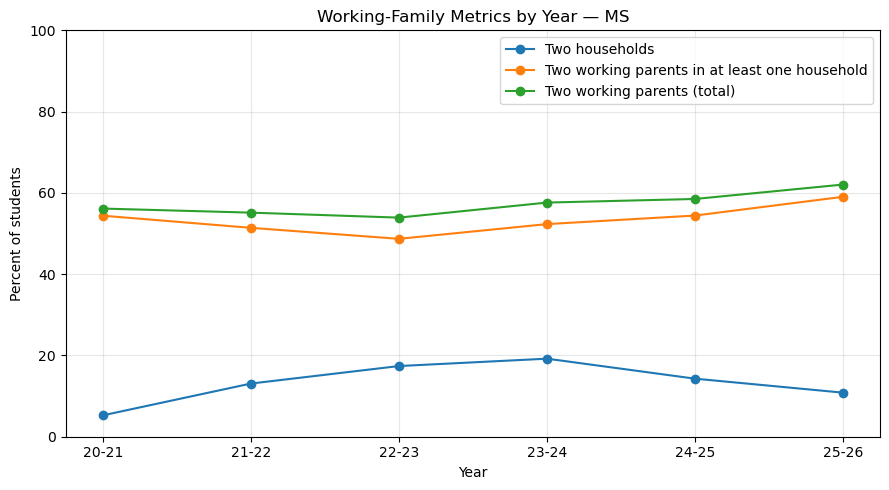

In [69]:
# --- Year-over-year visual for working-family metrics (by school or "all") ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterable

METRICS = {
    "Two households": lambda d: d["Two_households"],
    "Two working parents in at least one household": lambda d: d["Two_working_in_one_household"],
    "Two working parents (total)": lambda d: (d["Total_working_parents"] >= 2),
    # "Three working parents": lambda d: (d["Total_working_parents"] >= 3),
    # "Four working parents": lambda d: (d["Total_working_parents"] >= 4),
}

def _subset_for_school(df: pd.DataFrame, school: str) -> pd.DataFrame:
    if school.lower() == "all":
        return df
    return df.loc[df["School_Level"] == school]

def print_student_counts(df: pd.DataFrame, years: Iterable[str], school: str = "all"):
    """
    Prints the number of students (rows) per year after filtering.
    - df: tidy dataframe (after prune + add_school_level and any filtering)
    - years: iterable of year labels
    - school: "LS", "MS", "HS", or "all"
    """
    sub = _subset_for_school(df, school)
    counts = (
        sub[sub["year"].isin(years)]
        .groupby("year", observed=True)
        .size()
        .reindex(years, fill_value=0)
    )

    title_school = school.upper() if school.lower() != "all" else "ALL SCHOOLS"
    print(f"\nStudent counts by year — {title_school}")
    print("-" * 40)
    for yr, n in counts.items():
        print(f"{yr}: {n:,}")
    print("-" * 40)
    print(f"Total across all listed years: {counts.sum():,}")

def _compute_metric_timeseries(df: pd.DataFrame, years: Iterable[str], school: str) -> pd.DataFrame:
    """
    Returns a DataFrame indexed by metric with columns=years, values=percent (0-100).
    Only includes rows for which the denominator (student count in that year/school) > 0.
    """
    sub = _subset_for_school(df, school)
    # keep only requested years; preserve input order
    sub = sub[sub["year"].isin(list(years))].copy()

    out = {}
    for yr, ydf in sub.groupby("year", observed=True, dropna=False):
        denom = len(ydf)
        if denom == 0:
            # fill NaN; will drop later
            out[yr] = {name: np.nan for name in METRICS}
            continue
        col = {}
        for name, fn in METRICS.items():
            col[name] = (fn(ydf).sum() / denom) * 100.0
        out[yr] = col

    ts = pd.DataFrame(out)
    # keep the requested year order; drop columns with all NaN
    ts = ts.reindex(columns=list(years)).dropna(axis=1, how="all")
    return ts

def plot_working_family_trends(df: pd.DataFrame, years: Iterable[str], school: str = "all"):
    """
    One chart with a line per metric across the selected years.
    - df: tidy dataframe (after prune + add_school_level)
    - years: list like ["22-23","23-24","24-25","25-26"]
    - school: "LS" | "MS" | "HS" | "all"
    """
    ts = _compute_metric_timeseries(df, years, school)
    if ts.empty:
        raise ValueError("No data for the requested years/school.")

    # Make x labels from columns, already ordered by the input 'years'
    x = np.arange(ts.shape[1])
    fig, ax = plt.subplots(figsize=(9, 5))
    for metric in ts.index:
        ax.plot(x, ts.loc[metric].values, marker="o", label=metric)

    # Title and labels (no specific colors/styles per your preferences)
    denom_by_year = {}
    sub = _subset_for_school(df, school)
    for yr in ts.columns:
        denom_by_year[yr] = int((sub["year"] == yr).sum())
    title_school = school.upper() if school.lower() != "all" else "ALL SCHOOLS"
    ax.set_title(f"Working-Family Metrics by Year — {title_school}")
    ax.set_xlabel("Year")
    ax.set_ylabel("Percent of students")
    ax.set_xticks(x, ts.columns)
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")

    # remove the annotation loop entirely
    plt.tight_layout()

    plt.tight_layout()
    return ts  # also return the underlying table in case you want to inspect/export

# --- Example usage ---
# years = ["22-23","23-24","24-25","25-26"]
school = "MS"
_ = plot_working_family_trends(tidy, years, school = school)
print_student_counts(tidy, years, school=school)
# _ = plot_working_family_trends(tidy, years, school="all")  # aggregate across schools